In [1]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse.linalg import spsolve

In [2]:
vertical = 'b'

In [3]:
def data_vert():# Полуаем dataframe с соответствующимим коэффициентами для пар взаимодействий user-item
    data1 = pd.read_csv('converted_users_' + vertical + '.csv')
    data2 = pd.read_csv('interested_users_' + vertical + '.csv')
    
    data2['Quantity'] = np.ones(data2.shape[0]) * 0.01
    data1['Quantity'] = np.ones(data1.shape[0]) * 0.1
    data1.loc[data1['action_type'].isin([0, 3, 4]), 'Quantity'] = 1
    data1 = data1.append(data2[data2.user_id.isin(set(data1.user_id))], ignore_index=True)
    
    gb = pd.DataFrame({'cnt': data1[data1.action_type.isin([0, 3, 4])].groupby('user_id').product_id.nunique()})
    indexes = set(gb[gb.cnt >= 2].index)
    
    return data1[data1.user_id.isin(indexes)]

In [4]:
retail_data = data_vert()
retail_data.head()

,date,user_id,product_id,action_type,Quantity
30,2020-06-08 16:01:59.0,18b183d3b54e78f861e0fb5e1d1a9b3468c6162f,192,0.0,1.0
31,2020-06-08 16:01:59.0,18b183d3b54e78f861e0fb5e1d1a9b3468c6162f,192,1.0,0.1
56,2020-07-10 01:14:31.0,8048929d12eba573eede3e7dc02c6f8226ad60a4,32,1.0,0.1
110,2020-08-28 12:41:13.0,09cec28a32a5f6765b621af60f25c5265407366d,35,1.0,0.1
126,2020-09-09 15:02:03.0,dd449d883201c796a3c59a1aa87c17cd57e0266f,527,1.0,0.1


In [5]:
retail_data.shape

(145360, 5)

In [6]:
def get_encoders(data): # возвращает словари чтобы проиндексировать id-шки и поменять их
    uid = dict(enumerate(data.user_id.unique())) #index to id
    uidx = dict([(i[1], i[0]) for i in uid.items()])
    pid = dict(enumerate(data.product_id.unique())) #index to id
    pidx = dict([(i[1], i[0]) for i in pid.items()])
    
    return uid, uidx, pid, pidx

In [7]:
uid, uidx, pid, pidx = get_encoders(retail_data)

In [8]:
print(len(uid), len(pid))

3470 74


In [9]:
def get_only_one_purchase(retail_data): # возвращает датафрейм с уникальными покупками для каждого юзера
    data1 = pd.read_csv('converted_users_' + vertical + '.csv')
    
    data1 = data1[data1.action_type.isin([0, 3, 4])]
    data1 = data1[data1.user_id.isin(set(retail_data.user_id))]

    data1['Quantity'] = np.ones(data1.shape[0])
    
    data1 = data1.groupby(['user_id', 'product_id']).max().reset_index()

    return data1

In [10]:
only_one_purchase = get_only_one_purchase(retail_data)
only_one_purchase.head()

,user_id,product_id,date,action_type,Quantity
0,0011d2c7700620cb3ff63b2d9ef747e3c55050b9,1288,2021-05-14 10:13:17.0,3,1.0
1,0011d2c7700620cb3ff63b2d9ef747e3c55050b9,1391,2021-04-06 11:55:20.0,3,1.0
2,0037b45303116c52c0bef1084e88569d2796a52b,1288,2021-05-10 12:52:02.0,3,1.0
3,0037b45303116c52c0bef1084e88569d2796a52b,1391,2021-06-05 13:28:22.0,3,1.0
4,003a6a024d6dc68609c8b0601d24cb23e8694aca,32,2021-01-19 17:55:27.0,0,1.0


In [11]:
# меняем id на индексы
retail_data.user_id = retail_data.user_id.apply(lambda x : uidx[x])
retail_data.product_id = retail_data.product_id.apply(lambda x : pidx[x])

only_one_purchase.user_id = only_one_purchase.user_id.apply(lambda x : uidx[x])
only_one_purchase.product_id = only_one_purchase.product_id.apply(lambda x : pidx[x])

In [12]:
def get_sparse_matrix(cleaned_retail, mshape): # возвращает разреженную матрицу для данного dataframe 
    cleaned_retail = cleaned_retail[['product_id', 'Quantity', 'user_id']] # Get rid of unnecessary info
    grouped_cleaned = cleaned_retail.groupby(['user_id', 'product_id']).sum().reset_index() # Group together
#     print(grouped_cleaned[grouped_cleaned.Quantity == grouped_cleaned.Quantity.max()])
    if (grouped_cleaned[grouped_cleaned.Quantity <= 0].shape[0] > 0):
        print("OUPS... :/")
        grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1 # Replace a sum of zero purchases with a one to
        # indicate purchased
    grouped_purchased = grouped_cleaned.query('Quantity > 0') # Only get customers where purchase totals were positive
    
    customers = list(np.sort(grouped_purchased.user_id.unique())) # Get our unique customers
    products = list(grouped_purchased.product_id.unique()) # Get our unique products that were purchased
    quantity = list(grouped_purchased.Quantity) # All of our purchases

    # rows = grouped_purchased.user_id.astype('category', categories = customers).cat.codes
#     rows = grouped_purchased.user_id.astype('category').cat.codes
    rows = grouped_purchased.user_id
    # Get the associated row indices
#     cols = grouped_purchased.product_id.astype('category').cat.codes 
    cols = grouped_purchased.product_id
    # Get the associated column indices
    purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=mshape)
    
    matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
    num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
    sparsity = 100*(1 - (num_purchases/matrix_size))
    print(sparsity)
    
    return purchases_sparse

In [13]:
purchases_sparse = get_sparse_matrix(retail_data, (len(uid), len(pid)))
only_purchases_sparse = get_sparse_matrix(only_one_purchase, (len(uid), len(pid)))

91.96627463198068
97.1142612352987


In [14]:
import random

def make_train(ratings, purchases, pct_test = 0.2): # создает train и test
    test_set = purchases.copy() # Make a copy of the original set to be the test set. 
#     test_set[test_set >= 1] = 1 # Store the test set as a binary preference matrix
#     test_set[test_set < 1] = 0
    
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = purchases.nonzero() # Find the indices in the ratings data where an interaction exists
    
#     print(type(training_set), training_set.shape)
#     nonzero_inds = [[], []]
#     for i in range(training_set.shape[0]):
#         for j in range(training_set.shape[1]):
#             if (training_set[i, j] >= 1):
#                 nonzero_inds[0].append(i)
#                 nonzero_inds[1].append(j)
#     nonzero_inds = pd.where(training_set >= 1)
    
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
#     nonzero_pairs = [(i, j) for i, j in nonzero_pairs if training_set[i, j] >= 1]
    
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    
    item_inds = [index[1] for index in samples] # Get the item column indices
    
#     removed_cnt = training_set[user_inds, item_inds].sum(axis=1)[0, 0]
#     total_cnt = ratings.sum(axis=0).sum(axis=1)[0, 0]
#     print(removed_cnt, total_cnt, removed_cnt / total_cnt)
    
#     training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero

    for user, prod in samples:
#         total = training_set[user, prod]
#         purch = purchases[user, prod]
#         if total - purch >= 1:
#             training_set[user, prod] = total - purch
#         else:
#             training_set[user, prod] = np.modf(training_set[user, prod])[0]
        training_set[user, prod] = np.modf(training_set[user, prod])[0]

    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    
    user_purchases = [set() for i in range(ratings.shape[0])]
    print(len(set(nonzero_pairs)), len(set(nonzero_pairs).difference(set(samples))))
    for user, prod in set(nonzero_pairs).difference(set(samples)):
        user_purchases[user].add(prod)
    
    return training_set, test_set, list(set(user_inds)), user_purchases, samples

In [15]:
product_train, product_test, product_users_altered, user_purchases, canceled_purchases = make_train(purchases_sparse, only_purchases_sparse, pct_test = 0.2)

7410 5928


In [16]:
users = list(range(product_train.shape[0]))
products = list(range(product_train.shape[1]))

users.sort(key=(lambda user : len(user_purchases[user])), reverse=True)
products.sort(key=(lambda prod : product_train[:, prod].sum()), reverse=True)

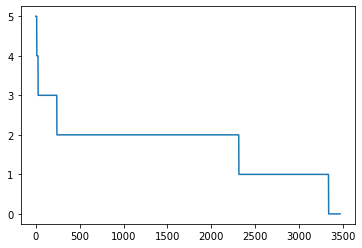

In [17]:
import matplotlib.pyplot as plt

plt.plot([len(user_purchases[user]) for user in users])

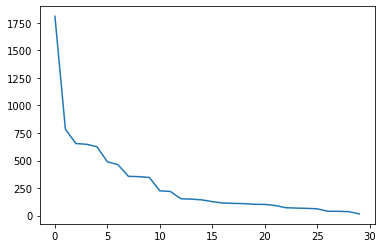

In [18]:
plt.plot(np.sort(product_train.sum(axis=0)[:,:30].tolist()[0])[::-1])

In [19]:
interesting_pairs = []

def fill_intp():
#     while True:
    for user in users:
        for prod in products:
            is_chosen = False
            if prod not in user_purchases[user]:
                interesting_pairs.append((user, prod))
                is_chosen = True
                break
        if len(interesting_pairs) >= 10000:
            return

fill_intp()
                
# for i in range(3000):
#     user = users[i]
#     for j in range(4):
#         prod = products[j]
#         if prod not in user_purchases[user]:
#             interesting_pairs.append((user, prod))

In [20]:
len(interesting_pairs)

3470

In [21]:
all_purchases = set(zip(only_one_purchase.user_id, only_one_purchase.product_id))

sum_cor = 0
sum_total = 0
for user, prod in interesting_pairs:
    if user in product_users_altered:
        sum_total += 1
        if (user, prod) in all_purchases:
            sum_cor += 1
print(sum_cor)
print(sum_total)

347
1301


# Генерация рекомендаций

In [22]:
# обучение модели
users = list(range(product_train.shape[0]))
products = list(range(product_train.shape[1]))

users.sort(key=(lambda user : len(user_purchases[user])), reverse=True)
products.sort(key=(lambda prod : product_train[:, prod].sum()), reverse=True)


all_purchases = set(zip(only_one_purchase.user_id, only_one_purchase.product_id))

interesting_pairs = []
for user in users:
    for prod in products:
        if (user, prod) not in all_purchases:
            interesting_pairs.append((user, prod))
            break
#     if len(interesting_pairs) >= 10000:
#         return

offer_pairs_id = [(uid[user], pid[prod]) for user, prod in interesting_pairs]
pd.DataFrame(offer_pairs_id).to_csv('offer_pairs_PM_1009.csv')
# sum_cor = 0
# for user, prod in interesting_pairs:
#     if (user, prod) in all_purchases:
#         sum_cor += 1
        
# print(sum_cor)
# print(len(interesting_pairs))

In [24]:
top_users = []
# cnt = int(np.ceil(len(user_purchases) * 0.05))
cnt = 100
print(cnt)
for user in range(len(user_purchases)):
    if len(user_purchases[user]) >= 3:
        top_users.append(user)
        cnt -= 1
    if cnt <= 0:
        break

for user in range(len(user_purchases)):
    if len(user_purchases[user]) == 2:
        top_users.append(user)
        cnt -= 1
    if cnt <= 0:
        break
# gb = pd.DataFrame({'cnt': only_one_purchase.groupby('user_id').product_id.nunique()})
# top_users = set(gb[gb.cnt > 2].index)

# for alt_user in product_users_altered:
#     top_users.discard(alt_user)

100


## GAT

In [25]:
mat = product_train.dot(product_train.T).toarray()
mat.shape

(3470, 3470)

In [26]:
fat_edges = np.where(mat > 0) # for 10000 offers - 883 correct (from baseline - 1084 correct)
# fat_edges = np.where(mat > 1.4) # 640
involved_nodes = list(set(fat_edges[0]).union(set(fat_edges[1])))
edges = [(a, b, mat[a, b]) for a, b in zip(fat_edges[0], fat_edges[1])]
fat_edges[0].shape

(10330672,)

In [27]:
import networkx as nx
import pandas as pd
import numpy as np
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
nxG = nx.Graph()
nxG.add_weighted_edges_from(edges)
nxG.remove_edges_from(nx.selfloop_edges(nxG))

node_rates = retail_data.groupby('user_id').sum().reset_index()[['Quantity']]
G = sg.StellarGraph.from_networkx(nxG, node_features=node_rates[node_rates.index.isin(set(involved_nodes))])

In [29]:
generator = FullBatchNodeGenerator(G, method="gat")

In [30]:
node_subjects = involved_nodes
node_targets = product_train[involved_nodes].toarray()
Xy = list(zip(node_subjects, node_targets))

In [31]:
# train_subjects, val_subjects = model_selection.train_test_split(
#     Xy, train_size=int(len(node_subjects) * 0.8), stratify=node_subjects
# )

Xy_train, Xy_val = model_selection.train_test_split(
    Xy, train_size=int(len(node_subjects) * 0.8)
)

train_subjects = [i[0] for i in Xy_train]
train_targets = np.array([i[1] for i in Xy_train])

val_subjects = [i[0] for i in Xy_val]
val_targets = np.array([i[1] for i in Xy_val])

In [32]:
# train_gen = generator.flow(list(range(train_targets.shape[0])), train_targets)
train_gen = generator.flow(train_subjects, train_targets)

In [33]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["elu", "elu"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [34]:
x_inp, predictions = gat.in_out_tensors()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [35]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [36]:
val_gen = generator.flow(val_subjects, val_targets)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback_loss = EarlyStopping(
    monitor="val_loss", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback_loss = ModelCheckpoint(
    "logs/best_model_loss.h5", monitor="val_loss", save_best_only=True, save_weights_only=True
)

es_callback_acc = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback_acc = ModelCheckpoint(
    "logs/best_model_acc.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)
# es_callback = EarlyStopping(
#     monitor="loss", patience=20
# )  # patience is the number of epochs to wait before early stopping in case of no further improvement
# mc_callback = ModelCheckpoint(
#     "logs/best_model.h5", monitor="loss", save_best_only=True, save_weights_only=True
# )

In [38]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback_loss, mc_callback_loss, es_callback_acc, mc_callback_acc],
)

Epoch 1/10
1/1 - 11s - loss: 30.6037 - acc: 0.0068 - val_loss: 24.1397 - val_acc: 0.0014
Epoch 2/10
1/1 - 10s - loss: 30.3944 - acc: 0.0018 - val_loss: 24.0117 - val_acc: 0.0072
Epoch 3/10
1/1 - 10s - loss: 24.7680 - acc: 0.0018 - val_loss: 24.0051 - val_acc: 0.0072
Epoch 4/10
1/1 - 10s - loss: 26.0729 - acc: 0.0065 - val_loss: 21.8849 - val_acc: 0.0072
Epoch 5/10
1/1 - 10s - loss: 24.0261 - acc: 0.0000e+00 - val_loss: 20.5137 - val_acc: 0.0720
Epoch 6/10
1/1 - 10s - loss: 25.6701 - acc: 3.6023e-04 - val_loss: 20.2088 - val_acc: 0.0720
Epoch 7/10
1/1 - 11s - loss: 25.8864 - acc: 7.2046e-04 - val_loss: 18.4135 - val_acc: 0.0764
Epoch 8/10
1/1 - 10s - loss: 24.5256 - acc: 0.0072 - val_loss: 18.1331 - val_acc: 0.0764
Epoch 9/10
1/1 - 10s - loss: 24.0529 - acc: 0.0000e+00 - val_loss: 16.8225 - val_acc: 0.0764
Epoch 10/10
1/1 - 11s - loss: 24.9507 - acc: 0.0014 - val_loss: 16.6125 - val_acc: 0.0764


In [39]:
# model.save_weights('logs/best_model.h5')

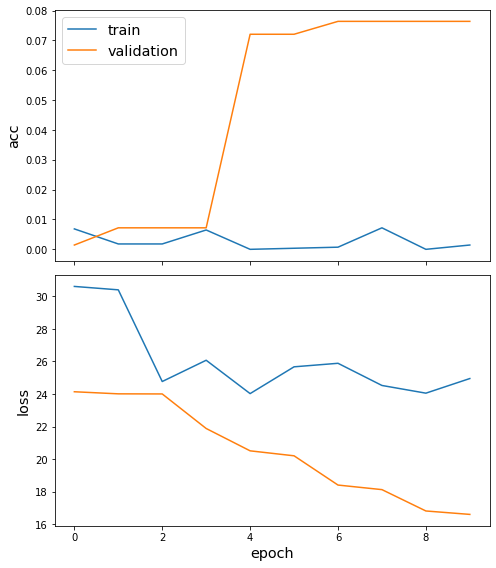

In [40]:
sg.utils.plot_history(history)

In [41]:
model.load_weights("logs/best_model_acc.h5")

In [42]:
# test_gen = generator.flow(test_subjects.index, test_targets)

In [43]:
# test_metrics = model.evaluate(test_gen)
# print("\nTest Set Metrics:")
# for name, val in zip(model.metrics_names, test_metrics):
#     print("\t{}: {:0.4f}".format(name, val))

In [44]:
emb_layer = next(l for l in model.layers if l.name.startswith("graph_attention"))
print(
    "Embedding layer: {}, output shape {}".format(emb_layer.name, emb_layer.output_shape)
)

Embedding layer: graph_attention_sparse, output shape (1, 3470, 64)


In [45]:
embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)

In [46]:
all_gen = generator.flow(train_subjects)
emb = embedding_model.predict(all_gen)
emb.shape

(1, 3470, 64)

In [47]:
emb = emb.squeeze()
list_embeddings = [None] * mat.shape[0]

for i in range(len(involved_nodes)):
    list_embeddings[involved_nodes[i]] = emb[i]
    
for i in range(len(list_embeddings)):
    if list_embeddings[i] is None:
        list_embeddings[i] = np.random.random(emb.shape[1])
        
node_embeddings = np.array(list_embeddings)

In [65]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [93]:
from sklearn.cluster import KMeans, DBSCAN, Birch, AgglomerativeClustering
from collections import Counter

def make_cluster(values, cluster, cl):
    ind = np.where(cluster == cl)
    new_clusters = AgglomerativeClustering(n_clusters=2).fit_predict(values[ind])
    new_clusters += cluster.max() + 1
    cluster[ind] = new_clusters
    return cluster
    print(dict(Counter(cluster)))
    print(dict(Counter(cluster[top_users])))

In [132]:
#clustering

from sklearn.cluster import KMeans, DBSCAN, Birch, AgglomerativeClustering
from collections import Counter

# cluster = DBSCAN(eps=6.95, min_samples=70).fit_predict(node_embeddings)
# cluster = KMeans().fit_predict(node_embeddings)
cluster = np.array([0] * node_embeddings.shape[0])

# cluster = np.array([0] * node_embeddings.shape[0])
# cluster = make_cluster(node_embeddings, cluster, 0)
# cluster = make_cluster(node_embeddings, cluster, 2)
# cluster = make_cluster(node_embeddings, cluster, 4)
# cluster = make_cluster(node_embeddings, cluster, 5)
# cluster = make_cluster(node_embeddings, cluster, 7)

# for new_cl, cl in enumerate(np.unique(cluster)):
#     np.place(cluster, cluster == cl, new_cl)

# cluster = Birch(n_clusters=10).fit_predict(node_embeddings)
# print(node_embeddings)

clusters_cnt = len(dict(Counter(cluster)))
# cluster = np.array([(clusters_cnt - 1 if cl == -1 else cl) for cl in cluster]) # '-1'nodes gathered into one cluster
print(dict(Counter(cluster)))
print(dict(Counter(cluster[top_users])))

{0: 3470}
{0: 100}


In [133]:
# import umap.umap_ as umap

# # numpy.ndarray of size number of nodes times embeddings dimensionality
# # node_targets = cluster[[int(node_id) for node_id in train_subjects if node_id < len(cluster)]]
# node_targets = cluster[[int(node_id) for node_id in list(range(len(node_embeddings)))]]

# reducer = umap.UMAP()
# node_embeddings_2d = reducer.fit_transform(node_embeddings)
# # node_embeddings_2d = node_embeddings

# # draw the points
# # alpha = 0.7
# label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
# node_colours = [label_map[target] for target in node_targets]

# plt.figure(figsize=(10, 8))
# plt.scatter(
#     node_embeddings_2d[:, 0],
#     node_embeddings_2d[:, 1],
#     c=node_colours,
#     cmap="jet",
# #     alpha=alpha,
# )

In [134]:
nodes_by_cluster = [[] for i in range(len(cluster))]
top_by_cluster = [[] for i in range(len(cluster))]

for i in involved_nodes:
    nodes_by_cluster[cluster[i]].append(i)

# for i in top_users:
#     top_by_cluster[cluster[i]].append(i)
for cl in range(clusters_cnt):
    purchs_and_nodes = [(-len(user_purchases[user]), user) for user in nodes_by_cluster[cl]]
    top_count = int(np.ceil(len(purchs_and_nodes) * 0.05))
    purchs_and_nodes.sort()
    top_by_cluster[cl] = [user for _, user in purchs_and_nodes[:top_count]]

In [135]:
from scipy.spatial.distance import euclidean as get_dist

def find_nearest(ind1, ind2, v):
    dist = []
    nearest = []
    for i in ind1:
        if len(ind2) == 0:
            dist.append(-1)
            nearest.append(-1)
        elif i == ind2[0] and len(ind2) > 1:
            dist.append(get_dist(v[i], v[ind2[1]]))
            nearest.append(ind2[1])
        else:
            dist.append(get_dist(v[i], v[ind2[0]]))
            nearest.append(ind2[0])
        for j in ind2:
            if i == j:
                continue
            cdist = get_dist(v[i], v[j])
            if dist[-1] > cdist:
                dist[-1] = cdist
                nearest[-1] = j
    return dist, nearest

In [178]:
from scipy.spatial.distance import euclidean

# dist_ot = []
# nearest_ot = []
# for i in range(clusters_cnt):
#     a, b = find_nearest(nodes_by_cluster[i], top_by_cluster[i], node_embeddings)
# #     a, b = find_nearest(nodes_by_cluster[i], top_users, node_embeddings)
#     dist_ot.append(a)
#     nearest_ot.append(b)
    
dist_ot = []
nearest_ot = []
predicted_ratings = np.zeros(product_train.shape)
for cl in range(clusters_cnt):
    for user in nodes_by_cluster[cl]:
        top_by_cluster[cl].sort(key=(lambda x : euclidean(node_embeddings[user], node_embeddings[x])))
        for i, User in zip(range(100), top_by_cluster[cl]):
            dist = euclidean(node_embeddings[user], node_embeddings[User])
            for prod in user_purchases[User].difference(user_purchases[user]):
                predicted_ratings[user, prod] += 1 / (1 + dist)
#     a, b = find_nearest(nodes_by_cluster[i], top_by_cluster[i], node_embeddings)
# #     a, b = find_nearest(nodes_by_cluster[i], top_users, node_embeddings)
#     dist_ot.append(a)
#     nearest_ot.append(b)

In [179]:
# # user_purchases = [set() for i in range(len(cluster))]
# to_buy = [[] for i in range(len(cluster))]
# for cl in range(clusters_cnt):
#     for user, User in zip(nodes_by_cluster[cl], nearest_ot[cl]):
#         to_buy[user] = user_purchases[User].difference(user_purchases[user])
#         to_buy[user] = [prod for prod in to_buy[user] if purchases_sparse[user, prod] >= 0.01]

In [180]:
np.where(predicted_ratings[0] > 0.0)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 19,
       20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 37, 39, 40, 41, 48, 50],
      dtype=int64)

In [183]:
all_purchases = set(zip(only_one_purchase.user_id, only_one_purchase.product_id))
sum_off = 0
sum_cor = 0
ratings_off = []
for user in product_users_altered:
    for_user = np.where(predicted_ratings[user] >= 5.987)[0]
    sum_off += for_user.shape[0]
    for prod in for_user:
        if (user, prod) in all_purchases:
            sum_cor += 1
#     sum_off += len(to_buy[user])
#     for prod in to_buy[user]:
#         ratings_off.append(purchases_sparse[user, prod])
#         if (user, prod) in all_purchases:
#             sum_cor += 1
# print(np.array(ratings_off).mean())
print(sum_off)
print(sum_cor)
print(len(all_purchases))

10384
1009
7410


In [124]:
user = 3228
print(user_purchases[user])
print(product_train[user])
print(cluster[user])
# print(to_buy[user])
# print(product_train[nearest_ot[7][nodes_by_cluster[7].index(user)]])
nearest_ot

{9}
  (0, 3)	0.01
  (0, 9)	1.12
  (0, 14)	0.1
  (0, 17)	0.10000000000000009
  (0, 25)	0.02
0


[]

In [141]:
canceled_purchases

[(3228, 17),
 (1441, 22),
 (2884, 6),
 (3411, 27),
 (1572, 8),
 (146, 0),
 (963, 24),
 (1921, 11),
 (1822, 0),
 (1514, 29),
 (2987, 19),
 (3170, 19),
 (1127, 3),
 (1784, 19),
 (1339, 3),
 (2203, 17),
 (3417, 11),
 (806, 17),
 (1894, 19),
 (516, 27),
 (1050, 11),
 (518, 14),
 (2875, 17),
 (347, 7),
 (2337, 14),
 (3049, 11),
 (930, 7),
 (2005, 3),
 (2678, 8),
 (3092, 11),
 (2273, 8),
 (545, 11),
 (1153, 0),
 (362, 9),
 (2774, 3),
 (268, 8),
 (3446, 30),
 (3253, 3),
 (2595, 20),
 (1231, 3),
 (1767, 3),
 (2111, 19),
 (370, 3),
 (1322, 11),
 (1622, 5),
 (1176, 23),
 (2309, 28),
 (2424, 30),
 (754, 3),
 (2083, 17),
 (1786, 1),
 (1655, 8),
 (3311, 5),
 (1960, 5),
 (969, 14),
 (223, 6),
 (3070, 25),
 (2068, 5),
 (50, 11),
 (341, 19),
 (2735, 11),
 (3211, 11),
 (1494, 3),
 (2698, 11),
 (3151, 0),
 (2993, 11),
 (2533, 8),
 (2365, 6),
 (4, 6),
 (2313, 15),
 (1851, 30),
 (3163, 11),
 (3320, 20),
 (1241, 3),
 (905, 27),
 (2776, 3),
 (1212, 23),
 (2672, 19),
 (3331, 3),
 (226, 3),
 (705, 20),
 (2142

## Random Walks (graph of products)

In [20]:
# import json

# with open('matrix_adjency.json', 'w') as f:
#     json.dump(mat.tolist(), f)

In [21]:
# import json

# with open('matrix_adjency.json') as f:
#     mat = np.array(json.load(f))

In [ ]:
p

In [22]:
import networkx as nx
import stellargraph as sg
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import umap.umap_ as umap

In [23]:
G = nx.Graph(mat)
G.remove_edges_from(nx.selfloop_edges(G))

G = sg.StellarGraph.from_networkx(G)

rw = sg.data.BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=10,  # maximum length of a random walk
    n=2,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
# walks = rw.run(
#     nodes=list(G.nodes()),
#     length=20,
#     n = 5,
# )
print("Number of random walks: {}".format(len(walks)))

from gensim.models.word2vec import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, vector_size=64, window=5, min_count=0, sg=1, workers=2)
# The embedding vectors can be retrieved from model.wv using the node ID as key.
# print(model.wv["19231"].shape)

# Retrieve node embeddings and corresponding subjects
node_embeddings = (
    model.wv.vectors
)
# node_ids = model.wv.index_to_key  # list of node IDs
node_ids = list(range(0, node_embeddings.shape[0]))

Number of random walks: 12712


C:\Users\User\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


{7: 961, 6: 994, 3: 1096, 0: 847, 4: 1057, 2: 885, 1: 422, 5: 94}
{7: 29, 6: 27, 3: 30, 0: 7, 4: 6, 2: 1}


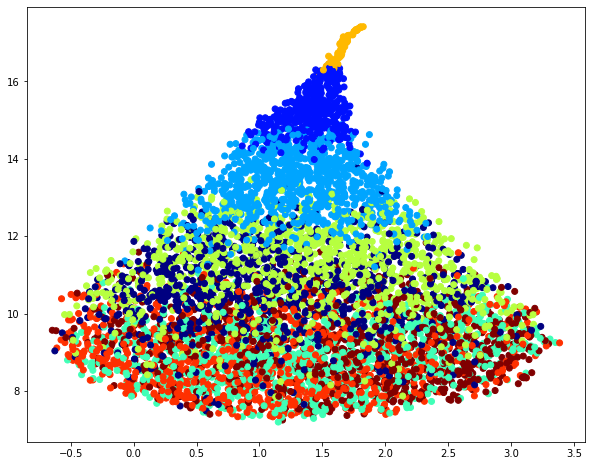

In [29]:
from sklearn.cluster import KMeans
from collections import Counter

# cluster = DBSCAN(eps=0.0785,min_samples=7).fit_predict(node_embeddings)
cluster = KMeans().fit_predict(node_embeddings)
# print(node_embeddings)
clusters_cnt = len(dict(Counter(cluster)))
print(dict(Counter(cluster)))
print(dict(Counter(cluster[top_users])))


# numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = cluster[[int(node_id) for node_id in node_ids]]

# Apply t-SNE transformation on node embeddings

# tsne = TSNE(n_components=2)
# node_embeddings_2d = tsne.fit_transform(node_embeddings)

reducer = umap.UMAP()
node_embeddings_2d = reducer.fit_transform(node_embeddings)
# node_embeddings_2d = node_embeddings

# draw the points
# alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
#     alpha=alpha,
)

In [25]:
from scipy.spatial.distance import euclidean as get_dist

def find_nearest(ind1, ind2, v):
    dist = []
    nearest = []
    for i in ind1:
        if len(ind2) == 0:
            dist.append(-1)
            nearest.append(-1)
        elif i == ind2[0] and len(ind2) > 1:
            dist.append(get_dist(v[i], v[ind2[1]]))
            nearest.append(ind2[1])
        else:
            dist.append(get_dist(v[i], v[ind2[0]]))
            nearest.append(ind2[0])
        for j in ind2:
            if i == j:
                continue
            cdist = get_dist(v[i], v[j])
            if dist[-1] > cdist:
                dist[-1] = cdist
                nearest[-1] = j
    return dist, nearest

In [30]:
nodes_by_cluster = [[] for i in range(len(cluster))]
top_by_cluster = [[] for i in range(len(cluster))]

for i in range(len(cluster)):
    nodes_by_cluster[cluster[i]].append(i)

for i in top_users:
    top_by_cluster[cluster[i]].append(i)
    
dist_ot = []
nearest_ot = []
for i in range(clusters_cnt):
#     a, b = find_nearest(nodes_by_cluster[i], top_by_cluster[i], node_embeddings)
    a, b = find_nearest(nodes_by_cluster[i], top_users, node_embeddings)
    dist_ot.append(a)
    nearest_ot.append(b)

In [43]:
# dict(zip(range(72), [[i] for i in only_purchases_sparse[nodes_by_cluster[2], :].sum(axis=0).tolist()[0]]))

In [439]:
# # research of clusters
# import matplotlib.pyplot as plt

# # for cl in range(clusters_cnt):
# #     print(only_purchases_sparse[nodes_by_cluster[cl], :].sum(axis=0))

# # x = list(zip(range(only_purchases_sparse.shape[1]), 
# #              only_purchases_sparse[nodes_by_cluster[0], :].sum(axis=0).tolist()[0]))
# plt.figure(figsize=(17, 5))
# x = only_purchases_sparse[nodes_by_cluster[2], :].sum(axis=0).tolist()[0]

# df = pd.DataFrame(dict(zip(range(72), [[i] for i in only_purchases_sparse[nodes_by_cluster[1], :].sum(axis=0).tolist()[0]])))

# df.plot.bar()
# # plt.hist(x, 100, facecolor='g', alpha=0.75, histtype='bar')
# # plt.bar(x, 100)
# # for i in zip(range(only_purchases_sparse.shape[1]), only_purchases_sparse[nodes_by_cluster[0], :].sum(axis=0).tolist()[0]):
# #     print(i)

In [33]:
# user_purchases = [set() for i in range(len(cluster))]
to_buy = [0] * len(cluster)
for cl in range(clusters_cnt):
    for user, User in zip(nodes_by_cluster[cl], nearest_ot[cl]):
        to_buy[user] = user_purchases[User].difference(user_purchases[user])
        to_buy[user] = [prod for prod in to_buy[user] if purchases_sparse[user, prod] >= 0.01]

In [34]:
all_purchases = set(zip(only_one_purchase.user_id, only_one_purchase.product_id))
sum_off = 0
sum_cor = 0
ratings_off = []
for user in product_users_altered:
    sum_off += len(to_buy[user])
    for prod in to_buy[user]:
        ratings_off.append(purchases_sparse[user, prod])
        if (user, prod) in all_purchases:
            sum_cor += 1
print(np.array(ratings_off).mean())
print(sum_off)
print(sum_cor)
print(len(all_purchases))

0.17742813918305597
661
68
2587


In [17]:
def get_probabilities(graph, clusters):
#     num_of_cluster = {}
#     k = len(cluters)
#     total_weigts = [[0] * k for i in range(k)]
    for edge in nx.to_edgelist(graph):
        
# #         cl1 = num_of_cluster[i]
#         print(i)
#         for j in i:
# #             cl2 = num_of_cluster[j]
#             print(graph[i][j])
# #             total_weights[num_of_cluster[]]
    return 

IndentationError: expected an indented block (<ipython-input-17-891f882616e0>, line 13)

In [18]:
get_probabilities(g, partition)

NameError: name 'get_probabilities' is not defined

In [ ]:
import networkx as nx

# mat = np.array([[1, 5, 0],
#       [5, 1, 0],
#       [0, 0, 1]])
g = nx.Graph(mat)
g.remove_edges_from(nx.selfloop_edges(g))
# print(nx.to_edgelist(g))
nx.write_gml(g, 'graph.gml')
for i in g[0]:
    print(i)
print(g[0])

In [ ]:
import leidenalg as la
import igraph as ig

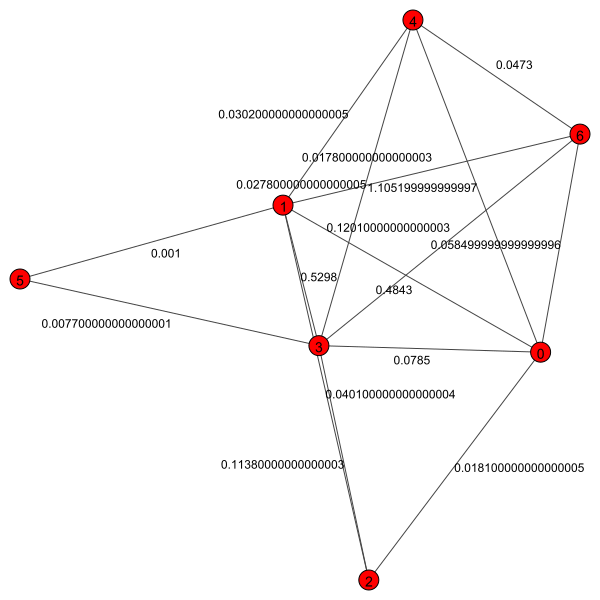

In [19]:
# mat = [[0, 2, 1],
#       [2, 0, 1],
#       [1, 1, 0]]
g = ig.Graph.Read_GML('graph.gml')
g.es['label'] = g.es['weight']
ig.plot(g, layout=g.layout('kk'))

In [20]:
print(g)

IGRAPH U-W- 7 15 --
+ attr: id (v), label (v), label (e), weight (e)
+ edges:
0 -- 1 2 3 4 6     2 -- 0 1 3         4 -- 0 1 3 6       6 -- 0 1 3 4
1 -- 0 2 3 4 5 6   3 -- 0 1 2 4 5 6   5 -- 1 3


In [36]:
partition = la.find_partition(g, la.ModularityVertexPartition)
print(partition)

Clustering with 7 elements and 2 clusters
[0] 1, 2, 3, 5
[1] 0, 4, 6


In [30]:
partition[0]

[1, 2, 3, 5]

In [39]:
for i in g.vs[0]:
    print(i)

TypeError: 'igraph.Vertex' object is not iterable

In [ ]:
# generator = FullBatchNodeGenerator(G, method="gat")

# train_gen = generator.flow(train_subjects.index, train_targets)

# gat = GAT(
#     layer_sizes=[8],
#     activations=["softmax"],
#     attn_heads=8,
#     generator=generator,
#     in_dropout=0.5,
#     attn_dropout=0.5,
#     normalize=None,
# )

# x_inp, predictions = gat.in_out_tensors()

# model = Model(inputs=x_inp, outputs=predictions)
# model.compile(
#     optimizer=optimizers.Adam(lr=0.005),
#     loss=losses.categorical_crossentropy,
#     metrics=["acc"],
# )

# history = model.fit(
#     train_gen,
#     epochs=50,
#     validation_data=val_gen,
#     verbose=2,
#     shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
#     callbacks=[es_callback, mc_callback],
# )